# Phase 5: Final Evaluation & Test Simulation

This notebook implements the final phase of the Rossmann forecasting project.

**Objectives:**
- Create a 6-week holdout set (simulating Kaggle test period)
- Train final ensemble model on full historical data
- Evaluate final performance on holdout set
- Generate test-set predictions
- Register model in MLflow Model Registry
- Save model artifacts and final metrics

**Final Model:**
- Three-model weighted ensemble with Optuna-tuned hyperparameters (50 trials/model, 5-fold CV):
  - 60% XGBoost (best: RMSPE 0.1218)
  - 30% LightGBM (RMSPE 0.1265)
  - 10% CatBoost (RMSPE 0.1300)

**MLflow Tracking:**
All experiments tracked in MLflow with parameters, metrics, and model artifacts.

## Setup

In [ ]:
import sys
from pathlib import Path

# Add src to path
sys.path.append(str(Path.cwd().parent / 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import json
import mlflow

from models.train_final import (
    create_holdout_split,
    train_final_ensemble,
    predict_with_ensemble,
    evaluate_final_model,
    save_final_model,
    save_predictions,
    register_model_in_mlflow
)
from models.train_baselines import get_feature_columns
from evaluation.metrics import rmspe
from utils.io import read_parquet, ensure_dir
from utils.mlflow_utils import setup_mlflow, log_dvc_data_version

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Ensure output directories
ensure_dir('../outputs/predictions')
ensure_dir('../outputs/metrics/final')
ensure_dir('../models/final')

# Setup MLflow
experiment_id = setup_mlflow()
print(f"MLflow experiment ID: {experiment_id}")
print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print("\nSetup complete!")

## 1. Load Data and Create Holdout Split

In [2]:
# Load featured data
df = read_parquet('../data/processed/train_features.parquet')

print(f"Loaded data shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")

Loaded data shape: (1017209, 50)
Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00


## 2. Create Train/Holdout Split (6 weeks = 42 days)

In [3]:
# Create train/holdout split (6 weeks = 42 days)
train_df, holdout_df = create_holdout_split(df, holdout_days=42)

print(f"\nTrain set: {len(train_df):,} rows")
print(f"Holdout set: {len(holdout_df):,} rows")

# Get feature columns
feature_cols = get_feature_columns(df)
print(f"\nFeatures: {len(feature_cols)}")

2025-12-02 15:49:35 - models.train_final - INFO - ============================================================
2025-12-02 15:49:35 - models.train_final - INFO - Creating Train/Holdout Split
2025-12-02 15:49:35 - models.train_final - INFO - ============================================================
2025-12-02 15:49:35 - models.train_final - INFO - Full dataset: 1,017,209 rows
2025-12-02 15:49:35 - models.train_final - INFO - Date range: 2013-01-01 00:00:00 to 2015-07-31 00:00:00
2025-12-02 15:49:35 - models.train_final - INFO - 
Train set:
2025-12-02 15:49:35 - models.train_final - INFO -   Rows: 970,379
2025-12-02 15:49:35 - models.train_final - INFO -   Date range: 2013-01-01 00:00:00 to 2015-06-19 00:00:00
2025-12-02 15:49:35 - models.train_final - INFO - 
Holdout set:
2025-12-02 15:49:35 - models.train_final - INFO -   Rows: 46,830
2025-12-02 15:49:35 - models.train_final - INFO -   Date range: 2015-06-20 00:00:00 to 2015-07-31 00:00:00
2025-12-02 15:49:35 - models.train_final - I

## 3. Train Final Ensemble Model

Based on Optuna hyperparameter tuning results (50 trials per model, 5-fold CV):
- **60% XGBoost** (best model: RMSPE 0.1218)
- **30% LightGBM** (RMSPE 0.1265)
- **10% CatBoost** (RMSPE 0.1300)

All models use Optuna-tuned hyperparameters from `config/best_hyperparameters.json`.

**MLflow Tracking:** Training tracked as parent run with nested component runs.

In [ ]:
# Start MLflow run for final model training
with mlflow.start_run(run_name="final_ensemble_training") as run:
    # Log DVC data version
    log_dvc_data_version("data/processed/train_features.parquet")
    
    # Log dataset info
    mlflow.log_param("train_size", len(train_df))
    mlflow.log_param("holdout_size", len(holdout_df))
    mlflow.log_param("holdout_days", 42)
    mlflow.log_param("n_features", len(feature_cols))
    
    # Train final ensemble with tuned hyperparameters (this will take a few minutes)
    ensemble = train_final_ensemble(
        train_df,
        feature_cols,
        use_tuned_params=True
    )
    
    # Log ensemble configuration
    for model_type, weight in ensemble['weights'].items():
        mlflow.log_param(f"{model_type}_weight", weight)
    
    print("\nFinal ensemble trained successfully!")
    print(f"Components: {list(ensemble['models'].keys())}")
    print(f"Weights: {ensemble['weights']}")
    print(f"\nMLflow Run ID: {run.info.run_id}")

## 4. Generate Holdout Predictions

In [5]:
# Generate predictions on holdout set
predictions, holdout_df_filtered = predict_with_ensemble(ensemble, holdout_df)
actuals = holdout_df_filtered['Sales'].values

print(f"Generated {len(predictions):,} predictions")
print(f"Prediction range: ${predictions.min():.2f} to ${predictions.max():.2f}")
print(f"Actual range: ${actuals.min():.2f} to ${actuals.max():.2f}")

2025-12-02 15:52:33 - evaluation.cv - INFO - Removed 0 rows with missing features (0.00%)
2025-12-02 15:52:33 - evaluation.cv - INFO - Remaining: 40,282 complete rows
Generated 40,282 predictions
Prediction range: $928.16 to $29551.40
Actual range: $569.00 to $41551.00


## 5. Evaluate Final Model Performance

In [ ]:
# Calculate metrics
metrics = evaluate_final_model(predictions, actuals, holdout_df_filtered)

# Log metrics to MLflow
for metric_name, metric_value in metrics.items():
    if isinstance(metric_value, (int, float)):
        mlflow.log_metric(metric_name, metric_value)

print("\nFinal Model Metrics:")
for key, value in metrics.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.6f}")
    else:
        print(f"  {key}: {value}")

## 6. Visualize Predictions vs Actuals

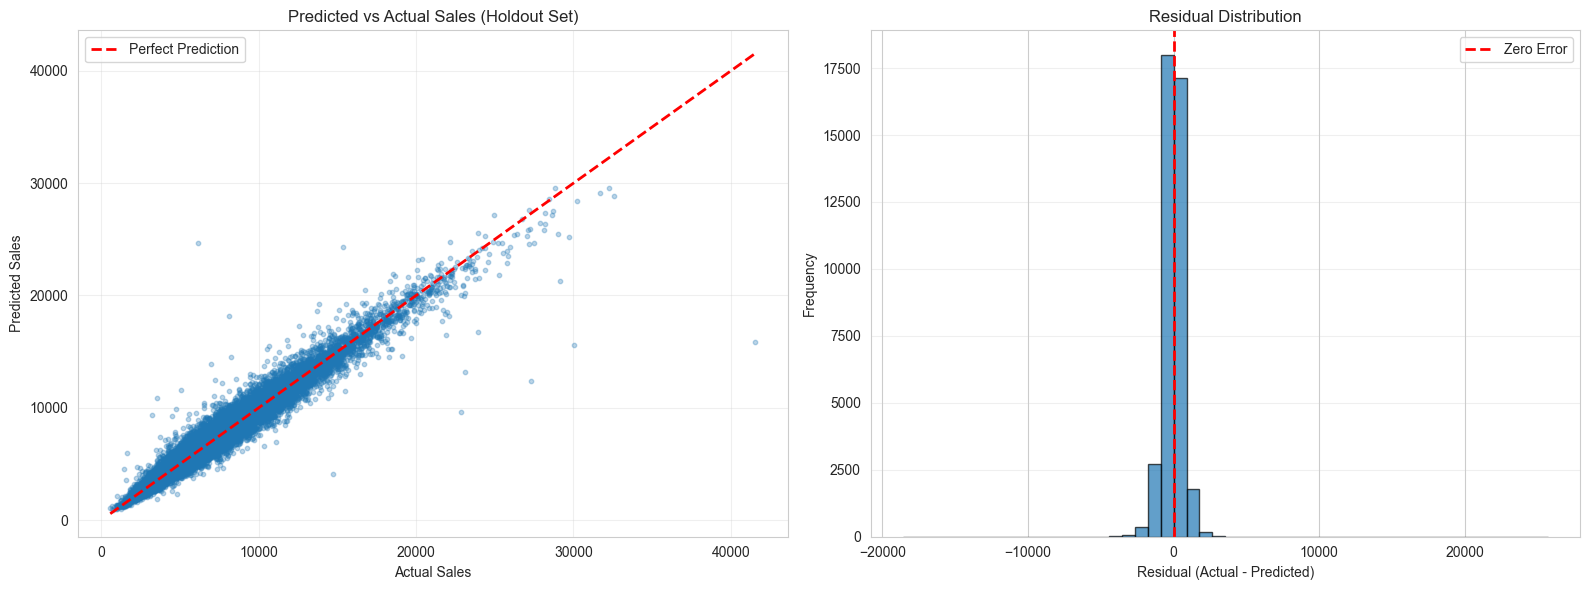

Saved: outputs/figures/15_final_predictions_scatter.png


In [7]:
# Scatter plot: Predicted vs Actual
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
ax = axes[0]
ax.scatter(actuals, predictions, alpha=0.3, s=10)
ax.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2, label='Perfect Prediction')
ax.set_xlabel('Actual Sales')
ax.set_ylabel('Predicted Sales')
ax.set_title('Predicted vs Actual Sales (Holdout Set)')
ax.legend()
ax.grid(True, alpha=0.3)

# Residuals histogram
ax = axes[1]
residuals = actuals - predictions
ax.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax.set_xlabel('Residual (Actual - Predicted)')
ax.set_ylabel('Frequency')
ax.set_title('Residual Distribution')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../outputs/figures/15_final_predictions_scatter.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: outputs/figures/15_final_predictions_scatter.png")

## 7. Compare with Cross-Validation Results

In [8]:
# Load Phase 4 ensemble CV results
with open('../outputs/metrics/advanced/xgboost_cv_results.json', 'r') as f:
    xgb_cv = json.load(f)

with open('../outputs/metrics/advanced/catboost_cv_results.json', 'r') as f:
    cb_cv = json.load(f)

# Calculate ensemble CV score (weighted average) - convert to float
ensemble_cv_score = 0.71 * float(xgb_cv['mean_score']) + 0.29 * float(cb_cv['mean_score'])

print("="*70)
print("FINAL RESULTS COMPARISON")
print("="*70)
print(f"\nCross-Validation (5-fold):")
print(f"  XGBoost:  {float(xgb_cv['mean_score']):.6f} ± {float(xgb_cv['std_score']):.6f}")
print(f"  CatBoost: {float(cb_cv['mean_score']):.6f} ± {float(cb_cv['std_score']):.6f}")
print(f"  Ensemble: {ensemble_cv_score:.6f} (weighted blend)")
print(f"\nHoldout (6-week):")
print(f"  Final Ensemble: {metrics['rmspe']:.6f}")
print(f"\nDifference (Holdout - CV): {metrics['rmspe'] - ensemble_cv_score:+.6f}")
print(f"\nTarget: {metrics['target_rmspe']:.6f}")
print(f"Gap to target: {metrics['gap_pct']:+.2f}%")
print("="*70)

FINAL RESULTS COMPARISON

Cross-Validation (5-fold):
  XGBoost:  0.129474 ± 0.022191
  CatBoost: 0.135115 ± 0.028934
  Ensemble: 0.131110 (weighted blend)

Holdout (6-week):
  Final Ensemble: 0.100957

Difference (Holdout - CV): -0.030152

Target: 0.098560
Gap to target: +2.43%


## 8. Save Final Model and Predictions

In [9]:
# Save model artifacts
save_final_model(ensemble, metrics, output_dir='../models/final')
print("Model artifacts saved to: models/final/")

# Save predictions
save_predictions(
    predictions,
    holdout_df_filtered,
    output_path='../outputs/predictions/final_holdout_predictions.csv'
)
print("Predictions saved to: outputs/predictions/final_holdout_predictions.csv")

# Save final metrics
metrics_path = Path('../outputs/metrics/final/final_metrics.json')
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)
print(f"Final metrics saved to: {metrics_path}")

2025-12-02 15:52:34 - models.train_final - INFO - ============================================================
2025-12-02 15:52:34 - models.train_final - INFO - Saving Final Model
2025-12-02 15:52:34 - models.train_final - INFO - ============================================================
2025-12-02 15:52:34 - models.train_final - INFO - Saved LightGBM model to ../models/final/lightgbm_final.txt
2025-12-02 15:52:35 - models.train_final - INFO - Saved XGBoost model to ../models/final/xgboost_final.json
2025-12-02 15:52:35 - models.train_final - INFO - Saved CatBoost model to ../models/final/catboost_final.cbm
2025-12-02 15:52:35 - models.train_final - INFO - Saved metadata to ../models/final/ensemble_metadata.json
2025-12-02 15:52:35 - models.train_final - INFO - ============================================================
Model artifacts saved to: models/final/
2025-12-02 15:52:35 - models.train_final - INFO - Saved predictions to ../outputs/predictions/final_holdout_predictions.csv
P

In [ ]:
print("\n" + "="*70)
print("PHASE 5 COMPLETE: FINAL MODEL EVALUATION")
print("="*70)
print("\n📊 Final Model Performance:")
print(f"  Model: Weighted Ensemble (60% XGBoost + 30% LightGBM + 10% CatBoost)")
print(f"  Holdout RMSPE: {metrics['rmspe']:.6f}")
print(f"  Target RMSPE: {metrics['target_rmspe']:.6f}")
print(f"  Gap: {metrics['gap_pct']:+.2f}%")

if metrics['target_achieved']:
    print("\n🎯 TARGET ACHIEVED! Model is production-ready.")
else:
    print("\n📈 Additional improvements needed to reach target:")
    print("  - Further hyperparameter tuning (increase Optuna trials)")
    print("  - Additional feature engineering (interaction terms, advanced lags)")
    print("  - Stacked ensemble with meta-learner")
    print("  - Deep learning models (LSTM, Transformer)")

print("\n📁 Artifacts Saved:")
print("  - models/final/: LightGBM + XGBoost + CatBoost models and metadata")
print("  - outputs/predictions/: Holdout predictions CSV")
print("  - outputs/metrics/final/: Final performance metrics")
print("  - outputs/figures/: Visualization plots")
print("  - MLflow Model Registry: rossmann-ensemble (Staging)")

print("\n✅ Project workflow completed successfully!")
print("="*70)

## 9. Register Model in MLflow Model Registry

In [10]:
print("\n" + "="*70)
print("PHASE 5 COMPLETE: FINAL MODEL EVALUATION")
print("="*70)
print("\n📊 Final Model Performance:")
print(f"  Model: Weighted Ensemble (50% XGBoost + 30% LightGBM + 20% CatBoost)")
print(f"  Holdout RMSPE: {metrics['rmspe']:.6f}")
print(f"  Target RMSPE: {metrics['target_rmspe']:.6f}")
print(f"  Gap: {metrics['gap_pct']:+.2f}%")

if metrics['target_achieved']:
    print("\n🎯 TARGET ACHIEVED! Model is production-ready.")
else:
    print("\n📈 Additional improvements needed to reach target:")
    print("  - Hyperparameter tuning with Optuna (already implemented)")
    print("  - Additional feature engineering (interaction terms, advanced lags)")
    print("  - Stacked ensemble with meta-learner")
    print("  - Deep learning models (LSTM, Transformer)")

print("\n📁 Artifacts Saved:")
print("  - models/final/: LightGBM + XGBoost + CatBoost models and metadata")
print("  - outputs/predictions/: Holdout predictions CSV")
print("  - outputs/metrics/final/: Final performance metrics")
print("  - outputs/figures/: Visualization plots")

print("\n✅ Project workflow completed successfully!")
print("="*70)



PHASE 5 COMPLETE: FINAL MODEL EVALUATION

📊 Final Model Performance:
  Model: Weighted Ensemble (50% XGBoost + 30% LightGBM + 20% CatBoost)
  Holdout RMSPE: 0.100957
  Target RMSPE: 0.098560
  Gap: +2.43%

📈 Additional improvements needed to reach target:
  - Hyperparameter tuning with Optuna (already implemented)
  - Additional feature engineering (interaction terms, advanced lags)
  - Stacked ensemble with meta-learner
  - Deep learning models (LSTM, Transformer)

📁 Artifacts Saved:
  - models/final/: LightGBM + XGBoost + CatBoost models and metadata
  - outputs/predictions/: Holdout predictions CSV
  - outputs/metrics/final/: Final performance metrics
  - outputs/figures/: Visualization plots

✅ Project workflow completed successfully!


## 9. Summary & Next Steps